# Installations

In [25]:
pip install sentencepiece nltk

Note: you may need to restart the kernel to use updated packages.


# Imports

In [26]:
import pandas as pd
import sentencepiece as spm
import re
import joblib
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec

# Commit to Github

In [27]:
!pwd                # shows your current folder
!git status         # check uncommitted changes
!git add .
!git commit -m "Creating vector representations"
!git push origin main

'pwd' is not recognized as an internal or external command,
operable program or batch file.


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


[main 977bed1] Creating vector representations
 6 files changed, 1810 insertions(+), 155 deletions(-)
 create mode 100644 count_vect.joblib
 create mode 100644 svd_lsa.joblib
 create mode 100644 tfidf_vect.joblib
 create mode 100644 word2vec.model


remote: error: Trace: a11ad2cbaaaa7644b554d18dfa8c910f17ea88194a1de6fc8fabff190bbc22d3        
remote: error: See https://gh.io/lfs for more information.        
remote: error: File svd_lsa.joblib is 131.90 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To https://github.com/Starlight0901/Reddit_SriLanka_Social_Insight.git
 ! [remote rejected] main -> main (pre-receive hook declined)
error: failed to push some refs to 'https://github.com/Starlight0901/Reddit_SriLanka_Social_Insight.git'


# Load the saved tokenizer

In [28]:
unigram = spm.SentencePieceProcessor()
unigram.load(r"C:\Users\tharu\Documents\GitHub\Reddit_SriLanka_Social_Insight\unigram.model")  # specify the correct path

# Encode text to token IDs
token_ids = unigram.encode("This is a sample post", out_type=int)

# Decode back to text
text = unigram.decode(token_ids)

print(token_ids)
print(text)

[7, 0, 1835, 30, 2700, 905, 5, 3671, 71]
 ⁇ his is a sample post


In [29]:
# Load dataset
df_posts = pd.read_csv("cleaned_Posts_Data.csv")
df_posts.head()

,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time,content_cleaned,word_count
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16,scam good investment haritha lanka agarwood pl...,32
1,post,new,no keyword,1ot9w1v,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,no post,2025-11-10,10:00:29,s hot sri lanka title say gimme hot,8
2,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57,need advice expert plan podcast friend short e...,57
3,post,new,no keyword,1ot9dyw,hotstar10,srilanka,Confusion Over Paddock Club Nugegoda’s Halal S...,0.0,4.0,no post,2025-11-10,09:28:19,confusion paddock club nugegoda s halal status...,41
4,post,new,no keyword,1ot9da2,prav_u,srilanka,Tour to Kanneliya Rain Forest I’m planning a g...,1.0,1.0,no post,2025-11-10,09:26:59,tour kanneliya rain forest m plan group visit ...,32


In [30]:
# Encode text to token IDs using the loaded tokenizer
df_posts['tokens'] = df_posts['content_cleaned'].apply(lambda x: unigram.encode(x, out_type=int))

In [31]:
df = df_posts.copy()

In [32]:
#  Sparse Representations

count_vect = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
X_count = count_vect.fit_transform(df['content_cleaned'])
print("Count shape:", X_count.shape)

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
X_tfidf = tfidf_vect.fit_transform(df['content_cleaned'])
print("TF-IDF shape:", X_tfidf.shape)

#  Dense: LSA (Truncated SVD)

svd_components = 100
svd = TruncatedSVD(n_components=svd_components, random_state=42)
X_lsa = svd.fit_transform(X_tfidf)
print("LSA shape:", X_lsa.shape)

#  Dense: Word2Vec Embeddings
print("\nTraining Word2Vec model...")

# 1. Tokenize text
documents = df['content_cleaned'].astype(str).apply(lambda x: x.split()).tolist()

# Train Word2Vec
w2v_dim = 300  # embedding dimension
w2v_model = Word2Vec(
    sentences=documents,
    vector_size=w2v_dim,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

# 3. Build document embeddings
def doc_vector(words):
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_dim)
    return np.mean(vectors, axis=0)

X_w2v = np.array([doc_vector(doc) for doc in documents])
print("Word2Vec shape:", X_w2v.shape)

# Save model
w2v_model.save("word2vec.model")

print("\nAll vector representations generated successfully.")


Count shape: (48028, 172884)
TF-IDF shape: (48028, 172884)
LSA shape: (48028, 100)

Training Word2Vec model...
Word2Vec shape: (48028, 300)

All vector representations generated successfully.


## **Justification of Vector Representations**

### **1. Sparse Representations**

**a) Count Vector (Bag-of-Words)**

* Choice: CountVectorizer with unigrams and bigrams.
* Reason:
  * Captures raw frequency of words/phrases in each document.
  * Bigrams help detect short phrases and context (**“not good”**, **“high risk”**).
  * Sparse format is memory-efficient for high-dimensional data.
* **Dimension:** `(48028, 172884)` → 48k posts × 172k vocabulary features.

**b) TF-IDF Vector**

* **Choice:** TfidfVectorizer with unigrams and bigrams.
* **Reason:**

  * Improves on raw counts by down-weighting very common words and up-weighting discriminative terms.
  * Reduces noise and highlights informative features for clustering/classification.
* **Dimension:** `(48028, 172884)` → same vocabulary, different feature weighting.

### **2. Dense Representations**

**a) LSA (Truncated SVD)**

* **Choice:** Reduce TF-IDF matrix to 100 latent dimensions.
* **Reason:**

  * Captures **latent semantic structure** rather than raw word counts.
  * Reduces dimensionality from 172k → 100, making downstream models faster and less prone to overfitting.
  * Dense vectors allow similarity-based clustering (e.g., KMeans) to work better.
* **Dimension:** `(48028, 100)` → 48k documents × 100 latent features.

**b) Word2Vec (Average Word Embeddings)**

* **Choice:** Train 300-dimensional word embeddings and average per document.
* **Reason:**

  * Captures **semantic meaning** of words and documents, not just frequency.
  * Dense, compact, and suitable for clustering or classification.
  * Complementary to LSA because it uses **contextual similarity** rather than linear algebra on term-frequency.
* **Dimension:** `(48028, 300)` → 48k documents × 300-dimensional dense vectors.


 **Summary Table**

| Representation | Type   | Dimensionality  | Justification                                                                    |
| -------------- | ------ | --------------- | -------------------------------------------------------------------------------- |
| Count          | Sparse | (48028, 172884) | Captures raw term frequency with unigrams + bigrams; good baseline for ML        |
| TF-IDF         | Sparse | (48028, 172884) | Highlights informative terms, reduces noise from frequent words                  |
| LSA            | Dense  | (48028, 100)    | Reduces dimensionality, captures latent semantic structure for better clustering |
| Word2Vec       | Dense  | (48028, 300)    | Captures semantic meaning; dense embeddings improve similarity-based tasks       |


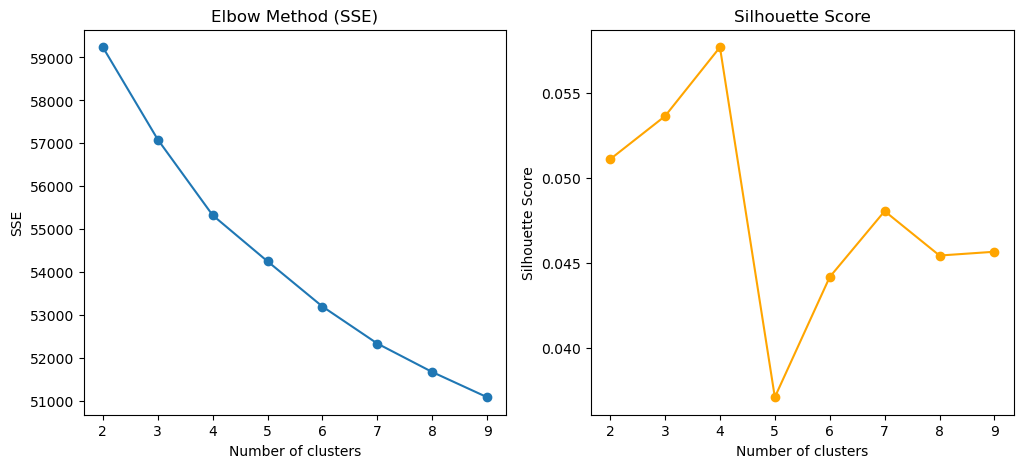

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Use Word2Vec
X_input = X_w2v 

# Try different k values
sse = []
sil_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_input)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_input, kmeans.labels_))

# Plot SSE (Elbow) and Silhouette Score
print("Silhouette Scores", sil_scores)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Use Word2Vec
X_input = X_w2v 

# Try different k values
sse = []
sil_scores = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_input)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_input, kmeans.labels_))

# Plot SSE (Elbow) and Silhouette Score
print("Silhouette Scores", sil_scores)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Use Word2Vec
X_input = X_w2v 

# Try different k values
sse = []
sil_scores = []
k_values = range(2, 20)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_input)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_input, kmeans.labels_))

# Plot SSE (Elbow) and Silhouette Score
print("Silhouette Scores", sil_scores)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Use Word2Vec
X_input = X_w2v 

# Try different k values
sse = []
sil_scores = []
k_values = range(5, 20)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_input)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_input, kmeans.labels_))

# Plot SSE (Elbow) and Silhouette Score
print("Silhouette Scores", sil_scores)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Use Word2Vec
X_input = X_w2v 

# Try different k values
sse = []
sil_scores = []
k_values = range(3, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_input)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_input, kmeans.labels_))

# Plot SSE (Elbow) and Silhouette Score
print("Silhouette Scores", sil_scores)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Use Word2Vec
X_input = X_w2v 

# Try different k values
sse = []
sil_scores = []
k_values = range(3, 25)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_input)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_input, kmeans.labels_))

# Plot SSE (Elbow) and Silhouette Score
print("Silhouette Scores", sil_scores)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [19]:
best_k = 4 

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_input)

print("Cluster distribution:")
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

Cluster distribution:
{np.int32(0): np.int64(6214), np.int32(1): np.int64(3039), np.int32(2): np.int64(5893), np.int32(3): np.int64(2124), np.int32(4): np.int64(5278), np.int32(5): np.int64(25480)}


In [20]:
df['category'] = labels

In [21]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=best_k, random_state=42, learning_method='batch', max_iter=20)
X_lda = lda.fit_transform(X_tfidf)  # document-topic distribution

# Assign dominant topic as category
lda_labels = X_lda.argmax(axis=1)
df['lda_category'] = lda_labels

In [22]:
def print_top_terms(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
        print(f"Topic {idx}: {', '.join(top_features)}")

tfidf_feature_names = tfidf_vect.get_feature_names_out()
print_top_terms(lda, tfidf_feature_names)

Topic 0: people, sri, like, country, lanka, sri lanka, good, think, know, government
Topic 1: like, sri, good, people, package, know, slt, lanka, sri lanka, dialog
Topic 2: sri, lanka, sri lanka, good, travel, colombo, like, day, visit, know
Topic 3: people, like, sri, good, know, lanka, sri lanka, think, time, go
Topic 4: degree, job, like, work, sri, good, university, year, lanka, sri lanka
Topic 5: sri, like, people, lanka, sri lanka, think, good, know, pay, country
